In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [328]:
sales = pd.read_csv("archive/bookstore_chain_AB_calgary_2019_2024_dataset/bookstore_sales.csv")

In [329]:
sales.head()

,date,year,month,store_id,channel,transactions,revenue,gst_collected,net_revenue,dataset
0,2019-01-01,2019,1,YYC-DT,IN_STORE,64,1985.46,99.27,1886.19,bookstore_sales
1,2019-01-01,2019,1,YYC-DT,ONLINE,8,207.72,10.39,197.33,bookstore_sales
2,2019-01-01,2019,1,YYC-NW,IN_STORE,49,1466.95,73.35,1393.60,bookstore_sales
3,2019-01-01,2019,1,YYC-NW,ONLINE,4,148.89,7.44,141.45,bookstore_sales
4,2019-01-01,2019,1,YYC-SE,IN_STORE,33,1272.70,63.64,1209.06,bookstore_sales


In [330]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13152 entries, 0 to 13151
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13152 non-null  object 
 1   year           13152 non-null  int64  
 2   month          13152 non-null  int64  
 3   store_id       13152 non-null  object 
 4   channel        13152 non-null  object 
 5   transactions   13152 non-null  int64  
 6   revenue        13152 non-null  float64
 7   gst_collected  13152 non-null  float64
 8   net_revenue    13152 non-null  float64
 9   dataset        13152 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 1.0+ MB


In [331]:
sales["date"] = pd.to_datetime(sales["date"])
sales = sales[sales["date"] >= "2020-01-01"]
sales = sales.sort_values("date").set_index("date")

In [332]:
sales.head()

,year,month,store_id,channel,transactions,revenue,gst_collected,net_revenue,dataset
date,,,,,,,,,
2020-01-01,2020,1,YYC-DT,IN_STORE,26,895.77,44.79,850.98,bookstore_sales
2020-01-01,2020,1,YYC-DT,ONLINE,13,497.38,24.87,472.51,bookstore_sales
2020-01-01,2020,1,YYC-NW,IN_STORE,23,729.69,36.48,693.21,bookstore_sales
2020-01-01,2020,1,YYC-NW,ONLINE,12,379.18,18.96,360.22,bookstore_sales
2020-01-01,2020,1,YYC-SE,IN_STORE,17,533.26,26.66,506.60,bookstore_sales


In [333]:
ts = sales["net_revenue"].resample("W").sum()

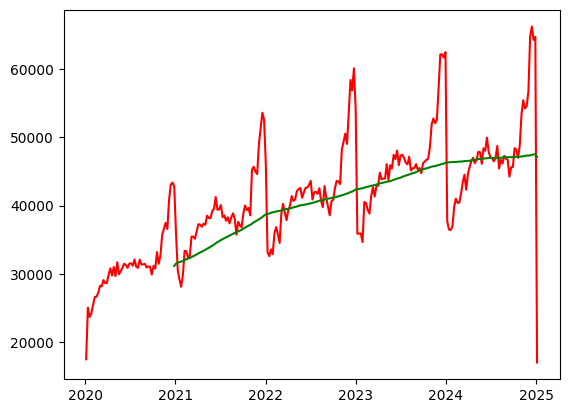

In [334]:
plt.plot(ts, '-r')
plt.plot(ts.rolling(window=52).mean(), '-g');

In [335]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(ts.values)
result[1]    

np.float64(0.1137601831894634)

In [336]:
ts = sales["net_revenue"].resample("ME").sum()

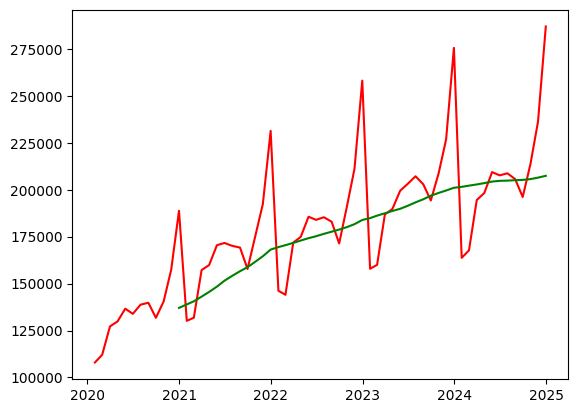

In [337]:
plt.plot(ts, '-r')
plt.plot(ts.rolling(window=12).mean(), '-g');

In [338]:
result = adfuller(ts.values)
result[1] 

np.float64(4.30754871126715e-10)

NO es estacionaria, mucho menos rudio en el mensual

In [339]:
ts_log = np.log(ts)

Estabiliza la varianza y suaviza picos. SARIMA funciona mejor

In [340]:
ts_log.head()

date
2020-01-31    11.589718
2020-02-29    11.626829
2020-03-31    11.753248
2020-04-30    11.773974
2020-05-31    11.824985
Freq: ME, Name: net_revenue, dtype: float64

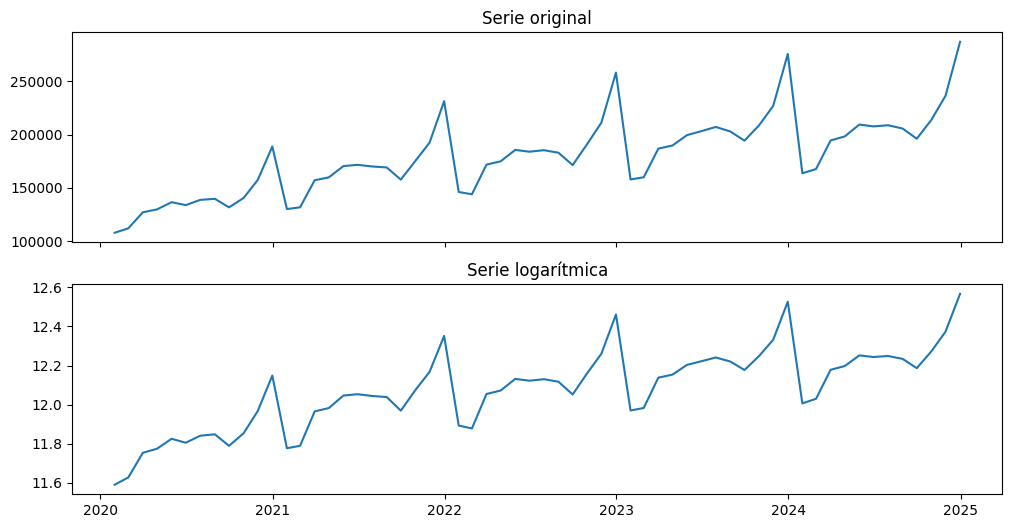

In [341]:
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

ax[0].plot(ts)
ax[0].set_title("Serie original")

ax[1].plot(ts_log)
ax[1].set_title("Serie logarítmica")

plt.show()


In [342]:
adfuller(ts_log)[1]

np.float64(1.7632570453303367e-16)

In [343]:
train = ts_log.iloc[:-12]
test = ts_log.iloc[-12:]

In [344]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from sklearn.metrics import mean_squared_error

In [345]:
auto_model = auto_arima(
    train,
    seasonal=True,
    m=12,
    d=1,
    D=1,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=2,
    max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-154.733, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-151.547, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-151.577, Time=0.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-152.965, Time=0.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-153.212, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-151.869, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-153.466, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-153.342, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-151.397, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-153.373, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.301 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(

In [346]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(0,1,0),
    seasonal_order=(0,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        net_revenue   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  76.080
Date:                            Mon, 12 Jan 2026   AIC                           -150.159
Time:                                    16:05:30   BIC                           -148.633
Sample:                                01-31-2020   HQIC                          -149.639
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007      0.000      5.922      0.000       0.000       0.001
Ljung-Box (L1) (Q):                

In [347]:
forecast_log = results.get_forecast(steps=len(test)).predicted_mean

In [348]:
import numpy as np

forecast = np.exp(forecast_log)
test_real = np.exp(test)

In [349]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test_real, forecast))
mae = mean_absolute_error(test_real, forecast)

rmse, mae

(np.float64(7872.626694003102), 7234.0410089337265)

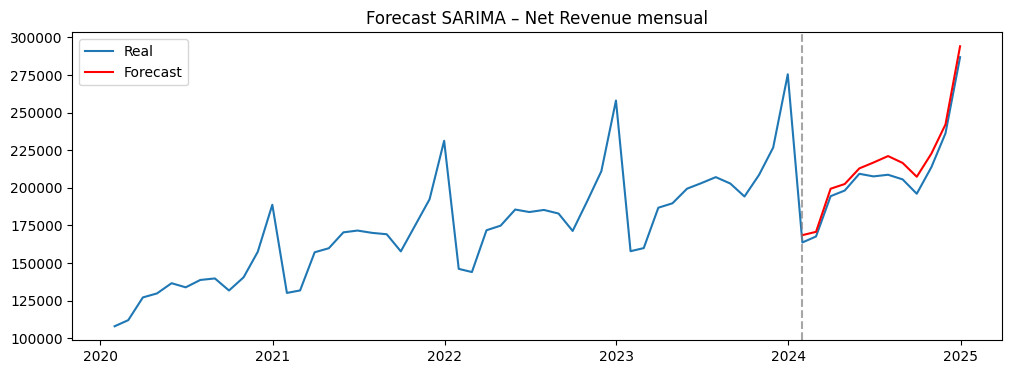

In [350]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(np.exp(ts_log), label="Real")
plt.plot(test_real.index, forecast, label="Forecast", color="red")
plt.axvline(test_real.index[0], color="gray", linestyle="--", alpha=0.7)
plt.legend()
plt.title("Forecast SARIMA – Net Revenue mensual")
plt.show()

In [351]:
future_log = results.get_forecast(steps=12).predicted_mean
future = np.exp(future_log)
future

2024-01-31    168572.058361
2024-02-29    170773.252312
2024-03-31    199439.217161
2024-04-30    202567.365032
2024-05-31    212954.785448
2024-06-30    216837.055550
2024-07-31    221147.662981
2024-08-31    216582.201139
2024-09-30    207397.545791
2024-10-31    222751.403118
2024-11-30    242142.405420
2024-12-31    294145.569794
Freq: ME, Name: predicted_mean, dtype: float64